In [1]:
import re
import os
import sys
import csv
import numpy as np 
import pandas as pd
import seaborn as sns
from prettytable import PrettyTable
from matplotlib import pyplot as plt
from Bio import SeqIO, pairwise2, AlignIO
from collections import Counter, namedtuple
from Bio.Align import AlignInfo, MultipleSeqAlignment
import importlib
# importlib.reload(sys.modules['Sequence'])
from Sequence import Sequence
from MultipleCutter import MultipleCutter
from Util.SeqUtil import seqInfo, parseFasta, parseSeqByCutter
from DataStructure import refSeqSimilarityInfo
from Evaluation.DfamEvaluation import DfamEvaluation
from SharedInfo import currDatasetName, cutterA, cutterB, colorA, colorB
from Util.AnalysisUtil import listToSortedCounter, getStatisticData, mostCommonTable
from Util.PlotUtil import basicPlot, twoLabelBasicPlot, lengthScatterDistributionPlot


In [2]:
outputFolder = "../outputFile"

In [3]:
seqA = Sequence(cutterA)
parseFastaA = seqA.parseFasta()
fragmentLenListA, fragmentSeqListA = seqA.parseSeqByCutter()
repeatInfoListA = seqA.findRepeatSeqs(lengthLimit=False)
filterRepeatInfoA = seqA.filterRepeatInfo() 
repeatPositionListA = seqA.getRepeatPositionList(filter=True)  # filter out identical
seqAState = seqA.seqStateGenerator()
seqA.generateRepeatFragentFile(filePath=f'{outputFolder}/seqRepeatPosition/seq_{cutterA}.txt')
# seqA.calculateConsistencyRatio(seqA.repeatPositionTable).sum() , seqA.calculateConsistencyRatio(seqA.repeatPositionTable).mean()

...start parsing dm6/chrX_sequence.fasta fasta file ...
...cost0.14202308654785156 sec to parse fasta file ...
...start parse seq by cutter: GATC
...cost 0.7399570941925049 sec to cut sequence
... start finding repeat seq ...
...cost0.06326985359191895 sec to finding repeat seq  ...


In [ ]:
matchStateLen = len(list(filter(lambda x: x == 1, seqAState)))
print(f'SeqState Output Percentage: {matchStateLen / len(parseFastaA[0])}')

SeqState Output Percentage: 0.037840232150925454


In [5]:
seqB = Sequence(cutterB)
parseFastaB = seqB.parseFasta()
fragmentLenListB, fragmentSeqListB = seqB.parseSeqByCutter()
repeatInfoListB = seqB.findRepeatSeqs(lengthLimit=False)
filterRepeatInfoB = seqB.filterRepeatInfo()
repeatPositionListB = seqB.getRepeatPositionList(filter=True)
seqBState = seqB.seqStateGenerator()
seqB.generateRepeatFragentFile(filePath=f'{outputFolder}/seqRepeatPosition/seq_{cutterB}')

...start parsing dm6/chrX_sequence.fasta fasta file ...
...cost0.15555381774902344 sec to parse fasta file ...
...start parse seq by cutter: AAGCTT
...cost 0.747204065322876 sec to cut sequence
... start finding repeat seq ...
...cost0.007175922393798828 sec to finding repeat seq  ...


In [35]:
matchStateLen = len(list(filter(lambda x: x == 1, seqAState)))
print(f'SeqState A Output Percentage: {matchStateLen / len(parseFastaA[0])}')

SeqState A Output Percentage: 0.037840232150925454


In [36]:
matchStateLen = len(list(filter(lambda x: x == 1, seqBState)))
print(f'SeqState B Output Percentage: {matchStateLen / len(parseFastaA[0])}')

SeqState B Output Percentage: 0.006023165734520684


In [31]:
seqA.calculateConsistencyRatio(seqA.repeatPositionTable).mean()

length              381.856549
consistencyRatio      0.665008
dtype: float64

In [32]:
seqB.calculateConsistencyRatio(seqB.repeatPositionTable).mean()

length              959.271186
consistencyRatio      0.899881
dtype: float64

In [8]:
seqInfo(currDatasetName, parseFastaA)

dm6/chrX_sequence dataset
 number of sequence:1
 total length:23542271



## Multiple cutters

In [9]:
multipleCutter = MultipleCutter(sequence=parseFastaA[0], seqStateList = [seqAState, seqBState])
mergeState = multipleCutter.getSeqStateSum()
unMatchState, unionState, intersectionState = multipleCutter.getSeqStateInfo()
stateName="intersection"
matchStateIdxList = multipleCutter.getSpecificStateIdxList(stateName)
matchStateRepeatInfoList = multipleCutter.getSpecificStatePositionList()

chr: 23542271
unMatch: 22630817, union:911454, intersection:121190


In [37]:
matchStateLen = len(list(filter(lambda x: x == 2, mergeState)))
print(f'SeqState Output Percentage: {matchStateLen / len(parseFastaA[0])}')

SeqState Output Percentage: 0.005147761658167982


## Repeat Seq -> Repeat Fragment

In [11]:
# totalRepeat = multipleCutter.cutRepeatSeqToFragment()
# multipleCutter.fragmentGroupbyLen()

In [38]:
df= pd.DataFrame(matchStateRepeatInfoList, columns=['length', 'startIdx', 'endIdx', 'seq'])

In [13]:
# # [ Output GroupByData File ]
# matchDfGroupByLen = df.groupby(by=["length"], sort=True)
# tem = df.groupby(by=["length"]).agg({"length": "sum"})

# original_stdout = sys.stdout
# with open(f'../outputFile/seqRepeatPosition/seqGroupByLenData_{stateName}_Cutter_{cutterA}.txt', 'w') as f:
#     sys.stdout = f
#     for key, row in tem.iterrows():
#         print(f"{key}:")
#         for i in matchDfGroupByLen.get_group(key).index:
#             print(f"({ df.iloc[i]['startIdx']}, {df.iloc[i]['endIdx']})\n{ df.iloc[i]['seq']}")
#         print("\n")
#     sys.stdout = original_stdout

In [15]:
# [ Singal Cutters ]
dfam = DfamEvaluation(repeatPositionListA, hitFileName='chrX_dm6_dfam.nrph.hits')
repeatPositionLookupDic = dfam.positionBucketClassifier()
dfamPositionList = dfam.getDfamPositionList()

# from Dfam , check repeat
DRrepeatMatchList, DRmatchedFamilyAccList, DRmatchedFamilyNameList = dfam.checkDfamMatchWithRepeat()

# from repeat , check Dfam
RDrepeatMatchList, RDmatchedFamilyAccList, RDmatchedFamilyNameList = dfam.checkRepeatMatchWithDfam()

# dfam.familyMatchRatio(DRmatchedFamilyAccList)
dfam.matchRatio(DRrepeatMatchList)

matchCount:612	dfamCount:4458	Ratio:0.13728129205921938


0.13728129205921938

In [39]:
unMatchDf = dfam.getUnmatchInfo(DRrepeatMatchList)

count     4341.000000
mean       602.378715
std       1058.456198
min      -2588.000000
25%        119.000000
50%        292.000000
75%        599.000000
max      11164.000000
dtype: float64


In [16]:
# [ Singal Cutters ]
dfam = DfamEvaluation(repeatPositionListB, hitFileName='chrX_dm6_dfam.nrph.hits')
repeatPositionLookupDic = dfam.positionBucketClassifier()
dfamPositionList = dfam.getDfamPositionList()

# from Dfam , check repeat
DRrepeatMatchList, DRmatchedFamilyAccList, DRmatchedFamilyNameList = dfam.checkDfamMatchWithRepeat()

# from repeat , check Dfam
RDrepeatMatchList, RDmatchedFamilyAccList, RDmatchedFamilyNameList = dfam.checkRepeatMatchWithDfam()

# dfam.familyMatchRatio(DRmatchedFamilyAccList)
dfam.matchRatio(DRrepeatMatchList)
# unMatchDf = dfam.getUnmatchInfo(DRrepeatMatchList)

matchCount:138	dfamCount:4458	Ratio:0.03095558546433378


0.03095558546433378

In [17]:
# [ Mltiplecutter, Intersection or Union ]
dfam = DfamEvaluation(matchStateRepeatInfoList, hitFileName='chrX_dm6_dfam.nrph.hits')
repeatPositionLookupDic = dfam.positionBucketClassifier()
dfamPositionList = dfam.getDfamPositionList()

# from Dfam , check repeat
DRrepeatMatchList, DRmatchedFamilyAccList, DRmatchedFamilyNameList = dfam.checkDfamMatchWithRepeat()

# from repeat , check Dfam
RDrepeatMatchList, RDmatchedFamilyAccList, RDmatchedFamilyNameList = dfam.checkRepeatMatchWithDfam()

# dfam.familyMatchRatio(DRmatchedFamilyAccList)
dfam.matchRatio(DRrepeatMatchList)
# unMatchDf = dfam.getUnmatchInfo(DRrepeatMatchList)

matchCount:117	dfamCount:4458	Ratio:0.026244952893674293


0.026244952893674293

In [18]:
# def getSequenceLengthAnalsis(inputLengthList, num=10):
#     """
#     1. count of common length 
#     2. statistic info
#     3. distribution plot
#     """
#     mostCommonTable(Counter(inputLengthList).most_common(num), num)
#     getStatisticData(inputLengthList)
#     sortedCounterList = listToSortedCounter(inputLengthList)
#     basicPlot(sortedCounterList)

In [19]:
# totalDfam = DfamEvaluation(repeatPositionList, hitFileName="chrX_dm6_dfam.nrph.hits")
# totalRepeatPositionLookupDic = totalDfam.positionBucketClassifier()
# totalDfamPositionList = totalDfam.getDfamPositionList()
# unionAndFilter_Position = pd.read_csv('../outputFile/txtFile/unionAndFilter_Position.csv')
# intersectionAndFilter_Position = pd.read_csv('../outputFile/txtFile/intersectionAndFilter_Position.csv')
# Filter_Position = pd.read_csv('../outputFile/txtFile/Filter_Position.csv')
# NonFilter_Position = pd.read_csv('../outputFile/txtFile/NonFilter_Position.csv')

# unionAndFilter_Counter = listToSortedCounter((unionAndFilter_Position['length']))
# intersectionAndFilter_Counter = listToSortedCounter((intersectionAndFilter_Position['length']))

In [20]:
# df = pd.DataFrame(columns=["x", "y", "type"], dtype=float)
# for row in unionAndFilter_Counter:
#     df = df.append({"x": row[0], "y": row[1], "type": "unionAndFilter"}, ignore_index=True)
# for row in intersectionAndFilter_Counter:
#     df = df.append({"x": row[0], "y": row[1], "type": "intersectionAndFilter"}, ignore_index=True)

# df.fillna(np.nan, inplace=True)
# fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
# sns.set_style("whitegrid")
# sns.lineplot(data=df, x="x", y="y", hue="type", palette="Set1")
# ax.set_xlabel("Length", size=15)
# ax.set_ylabel("Count", size=15)
# ax.set_xlim(0, 1500)

In [21]:
# # Dfam ref sequence 
# dfamSeqLenList = [ i.endIdx - i.startIdx for i in dfamPositionList ]
# getSequenceLengthAnalsis(dfamSeqLenList)

In [22]:
BS2df = pd.DataFrame(columns=['startIdx','endIdx','length','seq'])
for i in dfamPositionList:
    BS2df = BS2df.append({'startIdx': i.startIdx,'endIdx': i.endIdx ,'length':i.endIdx-i.startIdx,'seq': parseFastaA[0][i.startIdx: i.endIdx]}, ignore_index=True)
BS2df.to_csv('./Evaluation/Source/chrX_BS2_ref.csv', index=False)

In [23]:
# Repeat sequence
# repeatFragmentLenList = [ i.endIdx - i.startIdx for i in repeatPositionList ]
# getSequenceLengthAnalsis(repeatFragmentLenList)

In [24]:
alignments = pairwise2.align.globalxx("ACG", "ACCGT")
alignments[0].score / len("ACG")

1.0

In [25]:
def consensusSeqSimilarity(consensusSeq, seqDf):
    seqSimilarityList = []
    for targetSeq in seqDf:
        alignments = pairwise2.align.globalxx(targetSeq, consensusSeq)
        targetLength = len(targetSeq)
        similarityPercentage = round(alignments[0].score / targetLength, 2)
        seqSimilarityList.append(similarityPercentage)
    return seqSimilarityList

# repeatMatchIdxList = []
# for idx, value in enumerate(RDrepeatMatchList):
#     if value == True:
#         repeatMatchIdxList.append(idx)
# repeatBasePositionList = [repeatPositionList[i] for i in repeatMatchIdxList]
# repeatSeqDf = pd.DataFrame(columns=['startIdx','endIdx', 'length', 'seq'])
# for i in repeatBasePositionList:
#     repeatSeqDf = repeatSeqDf.append({'startIdx':i.startIdx ,'endIdx': i.endIdx, 'length': (i.endIdx- i.startIdx), 'seq': str(parseFastaA[0][i.startIdx:i.endIdx])}, ignore_index=True)
conParseFasta = parseFasta(
    "DF0001549_BS2",
    "./Evaluation/Source/DF0001549_BS2.fa",
    "*",
    matchMode=False,
)
consensusSeq = conParseFasta[0].upper()
repeatDf = pd.read_csv('./Evaluation/Source/chrX_BS2_ref.csv')
seqDf = repeatDf["seq"]
seqSimilarityList = consensusSeqSimilarity(consensusSeq, seqDf)
pd.Series(seqSimilarityList).describe()

...start parsing DF0001549_BS2 fasta file ...


FileNotFoundError: [Errno 2] No such file or directory: './Evaluation/Source/DF0001549_BS2.fa'

(0.0, 1.1)

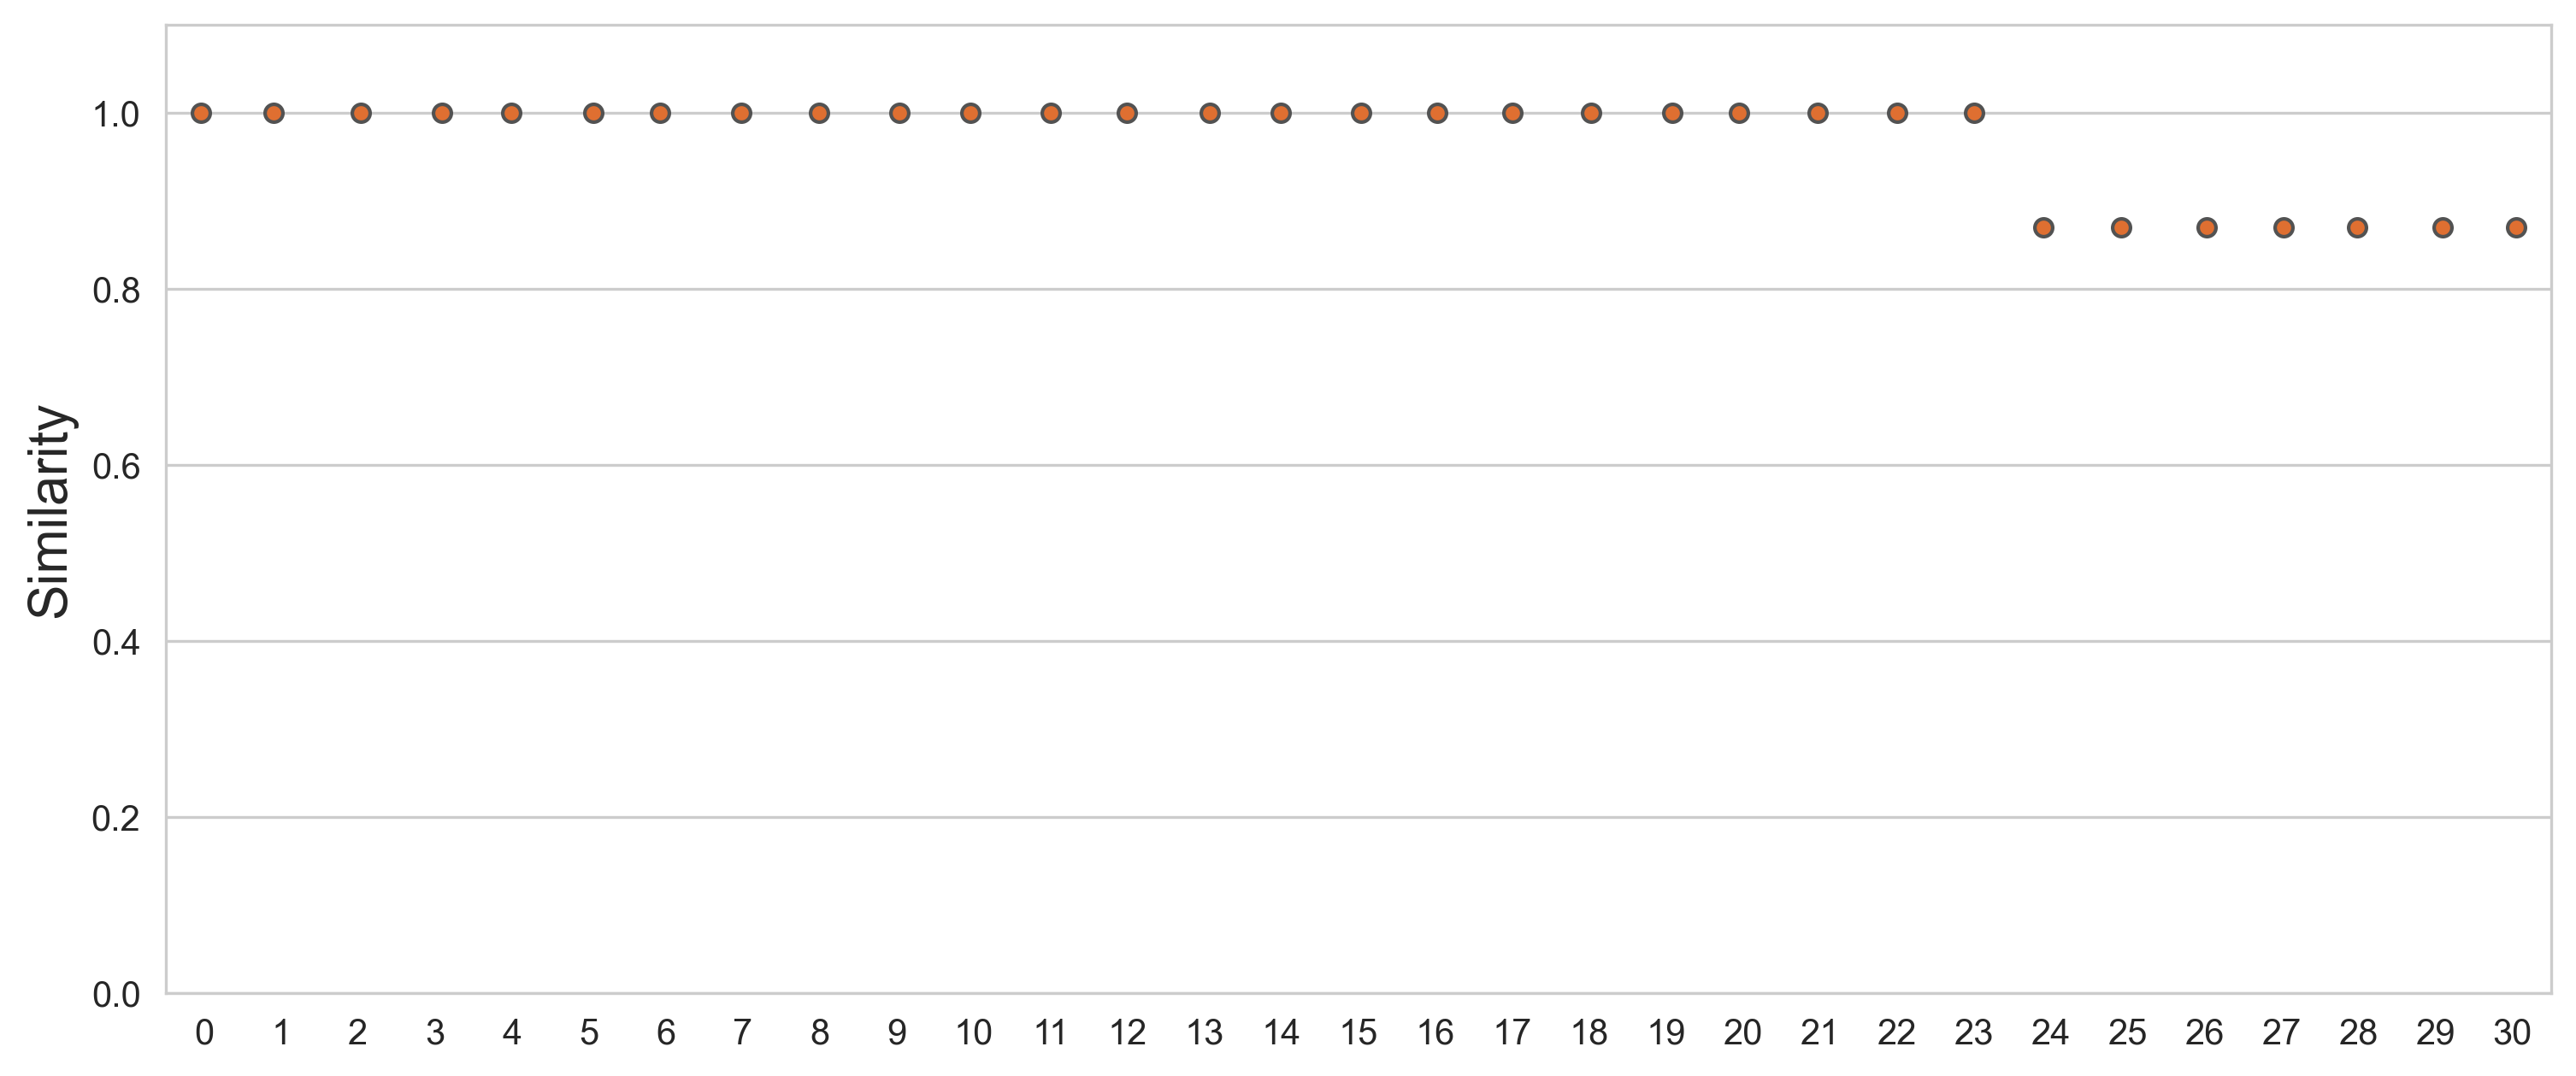

In [ ]:
xData = [*range(len(seqSimilarityList))]
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)
sns.set_style("whitegrid")
sns.stripplot(x=xData, y=seqSimilarityList, linewidth=1.0, color=colorA)
ax.set_ylabel("Similarity", size=15)
ax.set_ylim(0,1.1)

In [ ]:
# # Test cutter A
# repeatPositionListA = seqA.getRepeatPositionList()
# dfamA = DfamEvaluation(repeatPositionListA)
# repeatPositionLookupDicA = dfamA.positionBucketClassifier()
# dfamPositionListA = dfamA.getDfamPositionList()
# dfamPositionLookupDicA = dfamA.positionBucketClassifier()
# DRrepeatMatchListA, DRmatchedFamilyAccListA, DRmatchedFamilyNameListA = dfamA.checkDfamMatchWithRepeat()

In [ ]:
# totalLen = len(DRrepeatMatchListA)
# matchLenA = len(list(filter(lambda x: x, DRrepeatMatchListA)))
# ratio = matchLenA / totalLen
# print(f"matchCount:{matchLenA}\tdfamCount:{totalLen}\tRatio:{ratio}")

In [ ]:
# # Test cutter B
# repeatPositionListB = seqB.getRepeatPositionList()
# dfamB = DfamEvaluation(repeatPositionListB)
# repeatPositionLookupDicB = dfamB.positionBucketClassifier()
# dfamPositionListB = dfamB.getDfamPositionList()
# dfamPositionLookupDicB = dfamB.positionBucketClassifier()
# DRrepeatMatchListB, DRmatchedFamilyAccListB, DRmatchedFamilyNameListB = dfamB.checkDfamMatchWithRepeat()

In [ ]:
# totalLen = len(DRrepeatMatchListB)
# matchLenB = len(list(filter(lambda x: x, DRrepeatMatchListB)))
# ratio = matchLenB / totalLen
# print(f"matchCount:{matchLenB}\tdfamCount:{totalLen}\tRatio:{ratio}")

In [ ]:
# total = 597
# middle = matchLenA+matchLenB - total
# plt.figure(linewidth=10, facecolor="white", dpi=1200)
# # plt.figure(linewidth=10, facecolor="white")
# v = venn2(subsets = (matchLenA-middle, matchLenB-middle, middle), set_labels = (f'CutterA - {cutterA} ', f'CutterB - {cutterB}'), set_colors=(colorA, colorB))
# plt.show()
